In [71]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline

print("Pandas Version: " + pd.__version__)
print("Numpy Version: " + np.__version__)
print("Seaborn Version: " + sns.__version__)

Pandas Version: 1.1.2
Numpy Version: 1.19.2
Seaborn Version: 0.11.0


In [72]:
df = pd.read_csv("../data/call_a_bike/OPENDATA_BOOKING_CALL_A_BIKE.csv", sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16228298 entries, 0 to 16228297
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   BOOKING_HAL_ID             int64  
 1   CATEGORY_HAL_ID            int64  
 2   VEHICLE_HAL_ID             int64  
 3   CUSTOMER_HAL_ID            object 
 4   DATE_BOOKING               object 
 5   DATE_FROM                  object 
 6   DATE_UNTIL                 object 
 7   COMPUTE_EXTRA_BOOKING_FEE  object 
 8   TRAVERSE_USE               object 
 9   DISTANCE                   float64
 10  START_RENTAL_ZONE          object 
 11  START_RENTAL_ZONE_HAL_ID   float64
 12  END_RENTAL_ZONE            object 
 13  END_RENTAL_ZONE_HAL_ID     float64
 14  RENTAL_ZONE_HAL_SRC        object 
 15  CITY_RENTAL_ZONE           object 
 16  TECHNICAL_INCOME_CHANNEL   object 
dtypes: float64(3), int64(3), object(11)
memory usage: 2.1+ GB


In [107]:
df.sample(10)

,BOOKING_HAL_ID,CATEGORY_HAL_ID,VEHICLE_HAL_ID,CUSTOMER_HAL_ID,DATE_BOOKING,DATE_FROM,DATE_UNTIL,COMPUTE_EXTRA_BOOKING_FEE,TRAVERSE_USE,DISTANCE,START_RENTAL_ZONE,START_RENTAL_ZONE_HAL_ID,END_RENTAL_ZONE,END_RENTAL_ZONE_HAL_ID,RENTAL_ZONE_HAL_SRC,CITY_RENTAL_ZONE,TECHNICAL_INCOME_CHANNEL
7592305,32793850,53000,115876,09C1872C8F72354A296125C9EEC72C5F2608B778,2015-09-09 12:46:24,2015-09-09 12:46:24,2015-09-09 13:01:13,Nein,Nein,0.0,Uni-Kassel / Diagonale,204815.0,Friedenskirche / FES,204810.0,Standort,Kassel,IVR
13781908,42141981,51000,120453,F77856896DFDB74C604CAA847ABEDEFF0C27338C,2016-10-16 15:33:24,2016-10-16 15:33:24,2016-10-16 15:46:10,Nein,Nein,0.0,Sternschanze / Eingang Dänenweg,139501.0,Millerntorplatz/St.Pauli,131905.0,Standort,Hamburg,Android SRH
3743057,26770839,51000,117530,D0480A793383524AED918F59FB536B62484B236D,2014-10-26 20:33:37,2014-10-26 20:33:37,2014-10-26 20:40:32,Nein,Nein,0.0,Mundsburg / Schürbeker Straße,140799.0,Jarrestraße / Rambatzweg,138376.0,Standort,Hamburg,iPhone SRH
14060924,42575964,51000,119748,D1240B9F7FF89B56DBBB5D994E17ADFF61BAF28D,2016-11-04 17:00:43,2016-11-04 17:00:43,2016-11-04 17:06:04,Nein,Nein,0.0,Amsinckstraße/ Nordkanalbrücke,218174.0,Lange Reihe / Kirchenallee,138384.0,Standort,Hamburg,Android SRH
9080522,35277700,51000,115690,B1D057916D801920C2BD93EB15339735BEEA0C90,2016-01-26 08:17:55,2016-01-26 08:17:55,2016-01-26 08:41:40,Nein,Nein,0.0,Goebenstraße/Eppendorfer Weg,131641.0,Hauptbahnhof West / Glockengießer Wall,131872.0,Standort,Hamburg,iPhone SRH
10515221,37603407,51000,108626,C37E76E28FE5EB0C9CF896A56FAD6DB4AA9A26A2,2016-05-14 09:58:43,2016-05-14 09:58:43,2016-05-14 10:15:17,Nein,Nein,0.0,Alsterschwimmhalle/Ifflandstraße,198081.0,Wartenau / Lübecker Straße,140801.0,Standort,Hamburg,Terminal HH_94 (-2311-)
11352189,38783090,50000,108278,765DDB837557E90AAC73ABB7BDE87D99E180D224,2016-06-23 08:02:02,2016-06-23 08:02:02,2016-06-23 08:23:14,Nein,Nein,0.0,NaN,NaN,NaN,NaN,NaN,Darmstadt,Android CAB
2224700,24657544,50000,116336,A4F922D8A2E96C91D831D9EA875CD495B2B69CC9,2014-07-18 01:32:14,2014-07-18 01:32:14,2014-07-18 01:45:55,Nein,Nein,0.0,Fritzlarerstraße / Kirchplatz,214447.0,Oeder Weg / Oberweg,231575.0,Standort,Frankfurt am Main,iPhone CAB
10999574,38293430,51000,143644,00F0E13A87A45E4DDC46E12367B2277EFD5EA349,2016-06-07 02:50:48,2016-06-07 02:50:48,2016-06-07 03:06:55,Nein,Nein,0.0,Horner Rennbahn/ Meurer Weg,244938.0,Horner Rennbahn/ Meurer Weg,244938.0,Standort,Hamburg,Techniker HH_191 (-2566-)
16169548,46297508,53000,116711,86C50D17E73BFA18A72110B3BB826CBE6749E948,2017-05-13 03:04:22,2017-05-13 03:04:22,2017-05-13 03:23:02,Ja,Nein,0.0,Hauptbahnhof / Rainer-Dierichs-Platz,204812.0,Kirchditmold,204817.0,Standort,Kassel,Android KON


In [108]:
# Select trips made in Hamburg

trips = df[df.CITY_RENTAL_ZONE == "Hamburg"]

In [109]:
trips.isna().sum()

BOOKING_HAL_ID                    0
CATEGORY_HAL_ID                   0
VEHICLE_HAL_ID                    0
CUSTOMER_HAL_ID                   0
DATE_BOOKING                      0
DATE_FROM                         0
DATE_UNTIL                        0
COMPUTE_EXTRA_BOOKING_FEE         0
TRAVERSE_USE                      0
DISTANCE                        224
START_RENTAL_ZONE               429
START_RENTAL_ZONE_HAL_ID        246
END_RENTAL_ZONE                 255
END_RENTAL_ZONE_HAL_ID          250
RENTAL_ZONE_HAL_SRC             224
CITY_RENTAL_ZONE                  0
TECHNICAL_INCOME_CHANNEL     120066
dtype: int64

In [110]:
# Drop NaN rows since the amount is negligible

trips = trips.dropna()
trips.describe()

,BOOKING_HAL_ID,CATEGORY_HAL_ID,VEHICLE_HAL_ID,DISTANCE,START_RENTAL_ZONE_HAL_ID,END_RENTAL_ZONE_HAL_ID
count,8.821838e+06,8821838.0,8.821838e+06,8821838.0,8.821838e+06,8.821838e+06
mean,3.361258e+07,51000.0,1.212862e+05,0.0,1.702775e+05,1.706134e+05
std,7.296034e+06,0.0,1.071902e+04,0.0,4.173084e+04,4.178055e+04
min,2.136679e+07,51000.0,1.060220e+05,0.0,1.315430e+05,1.315430e+05
25%,2.705007e+07,51000.0,1.165570e+05,0.0,1.318870e+05,1.318880e+05
50%,3.339544e+07,51000.0,1.199210e+05,0.0,1.407960e+05,1.407960e+05
75%,3.996944e+07,51000.0,1.205110e+05,0.0,2.117090e+05,2.117090e+05
max,4.638670e+07,51000.0,1.438660e+05,0.0,2.683580e+05,2.683580e+05


In [111]:
# Select and rename usable columns

trips = trips[[
    "VEHICLE_HAL_ID",
    "CUSTOMER_HAL_ID",
    "DATE_FROM",
    "DATE_UNTIL",
    "START_RENTAL_ZONE",
    "START_RENTAL_ZONE_HAL_ID",
    "END_RENTAL_ZONE",
    "END_RENTAL_ZONE_HAL_ID",
    "TECHNICAL_INCOME_CHANNEL",
]].copy()
trips.columns = [
    "bike_id",
    "user_id",
    "date_from",
    "date_until",
    "from_station_name", 
    "from_station_id",
    "to_station_name",
    "to_station_id",
    "booked_via"
]

In [112]:
# Calculate duration in minutes (rounded up) for each trip

def calculate_duration_in_min(date_from, date_until):
    duration_in_seconds = pd.to_datetime(date_until) - pd.to_datetime(date_from)
    return np.ceil(duration_in_seconds / pd.Timedelta(minutes=1))

trips.loc[:, "duration_in_min"] = calculate_duration_in_min(trips["date_from"], trips["date_until"])

In [113]:
# Convert float to integer values where appropriate

trips["from_station_id"] = trips["from_station_id"].astype(int)
trips["to_station_id"] = trips["to_station_id"].astype(int)
trips["duration_in_min"] = trips["duration_in_min"].astype(int)

In [114]:
# Remove trips shorter than 3 minutes starting and ending at the same station
# These are probably trips that were not intentional or canceled due to issues with the bike

mask = (trips.duration_in_min < 3) & (trips.from_station_id == trips.to_station_id)
trips = trips.drop(trips[mask].index)

In [115]:
# Handling 'booked_via' that start with 'Techniker'

maintenance = trips[trips["booked_via"].str.contains("Techniker")]
trips_without_maintenance = pd.concat([trips, maintenance]).drop_duplicates(keep=False)

tmp = trips_without_maintenance.loc[trips_without_maintenance.user_id.isin(maintenance.user_id.unique())]
print('Number of trips with a user ID that booked via Techniker before: %s' % len(tmp.index))
tmp = trips_without_maintenance.loc[~trips_without_maintenance.user_id.isin(maintenance.user_id.unique())]
print('Number of trips with a user ID that did not book via Techniker before: %s' % len(tmp.index))

# Assuming 'Techniker' means maintenance personnel is probably faulty.
# Around 50% of the user IDs are contained in the non-maintenance trip data set.

Number of trips with a user ID that booked via Techniker before: 3858067
Number of trips with a user ID that did not book via Techniker before: 3841343


In [116]:
maintenance.sample(5)

,bike_id,user_id,date_from,date_until,from_station_name,from_station_id,to_station_name,to_station_id,booked_via,duration_in_min
13872228,106780,CAC60880CED12FAA9132CC6974494725DFA5AAB3,2016-10-22 21:46:49,2016-10-22 21:50:56,Friedensallee/Hegarstraße ( S Bahn Bahrenfeld ),244945,Hohenzollernring/Friedensallee,244944,Techniker HH_183 (-29-),5
14703138,110511,4508674D46A19467037330475ACC658FDCFB39F6,2017-01-14 00:55:53,2017-01-14 01:11:26,Moorstraße/Bahnhof Harburg,242358,Gotthelfweg/Außenmühlenteich,242732,Techniker HH_168 (-281-),16
6686669,143571,AFE435029D4660DE3628B0C1A26B52DABF2927A6,2015-07-21 07:39:12,2015-07-21 07:41:53,Lortzingstraße/Friedrichsberger Straße,213833,Krausestraße/Eilbektal,208295,Techniker HH_14 (-2337-),3
2727274,118987,0C6EB9B149A15160DF5CD17EA4CEF872B0A47432,2014-08-15 19:18:00,2014-08-15 19:32:44,Bebelallee/Meenkwiese,213855,Martinistraße / Haupteingang Klinikum,140793,Techniker HH_124 (-2383-),15
3224063,120467,182471C1032CB1B434E556EBD9048E2921F9BAA7,2014-09-18 19:54:37,2014-09-18 20:01:32,Bartholomäusstraße/Beim Alten Schützenhof,211923,Jarrestraße / Rambatzweg,138376,Techniker HH_12 (-2333-),7


In [117]:
# Remove outliers based on trip duration

threshold = trips.duration_in_min.quantile(0.9)
print('Trip duration threshold: %s minutes' % threshold)

trips = trips[trips.duration_in_min <= threshold]
trips.describe()

Trip duration threshold: 32.0 minutes


,bike_id,from_station_id,to_station_id,duration_in_min
count,7.554629e+06,7.554629e+06,7.554629e+06,7.554629e+06
mean,1.212814e+05,1.698610e+05,1.702034e+05,1.390638e+01
std,1.074445e+04,4.159115e+04,4.161839e+04,7.221086e+00
min,1.060220e+05,1.315430e+05,1.315430e+05,1.000000e+00
25%,1.164970e+05,1.318850e+05,1.318870e+05,8.000000e+00
50%,1.199190e+05,1.407960e+05,1.407960e+05,1.300000e+01
75%,1.205110e+05,2.117060e+05,2.117060e+05,1.900000e+01
max,1.438660e+05,2.683580e+05,2.683580e+05,3.200000e+01


<AxesSubplot:xlabel='duration_in_min'>

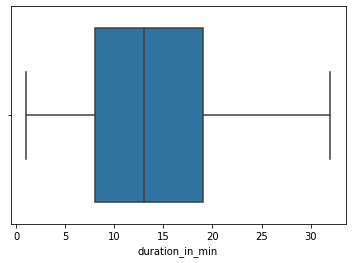

In [118]:
sns.boxplot(x=trips['duration_in_min'])

In [119]:
trips.sample(5)

,bike_id,user_id,date_from,date_until,from_station_name,from_station_id,to_station_name,to_station_id,booked_via,duration_in_min
14043495,119692,E9CB2C2171D46ED44C62814C182204D06B1A6DA8,2016-11-03 12:31:35,2016-11-03 12:38:34,Allende-Platz/Grindelhof,198077,Harvestehuder Weg / Alte Rabenstraße,137994,terminal HH_93 (-2215-),7
3393199,143823,2DDBCFA8113767207A3DD16CC5B1F550196FF2D5,2014-10-01 08:23:48,2014-10-01 08:49:47,Goldbekplatz / Semperstraße,140796,Schloßstrasse/Schloßgarten,207304,Terminal HH_73 (-2363-),26
958021,143546,6273EFB29B610F8BAB78E9E3B6B6F1B6D2F88338,2014-04-29 08:44:15,2014-04-29 08:49:35,U-Bahn Baumwall,214170,Domstraße/Willy-Brandt-Straße,213832,iPhone SRH,6
4938594,120403,9BC8FA99CBA8C6C451B4DF7E7985B5439FC4F999,2015-04-09 22:03:31,2015-04-09 22:07:58,U-Bahn Schlump,213679,Schulterblatt/Eifflerstraße,131648,Techniker HH_136 (-2221-),5
3639149,119847,B114E5C5C56C906E8AF71E2522F7353DC7F22D90,2014-10-18 17:55:32,2014-10-18 18:05:31,Landungsbrücke/Hafentor,131543,Mönckebergstraße / Steintorwall,138387,Android SRH,10


In [120]:
# Save clean data set as CSV

trips.to_csv("../data/trips.csv", index=False)